In [53]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
from utils.lick_utils import load_licks
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
warnings.filterwarnings('ignore')

%matplotlib inline

## Quality metrics

In [54]:
# load animal parameters
pickle_file = '/root/capsule/scratch/combined/combined_session_tbl/combined_beh_sessions.pkl'
target_folder = '/root/capsule/scratch/manuscript/F_beh'
with open(pickle_file, 'rb') as f:
    combined_session_tbl = pickle.load(f)
combined_session_tbl.loc[combined_session_tbl['p_st_w']==1, 'diff_1'] = 5

Applying bounds for session_len: [90, None]
 - session_len: 211 -> 210 units passed
Applying bounds for p_sw_L: [0.04, None]
 - p_sw_L: 210 -> 209 units passed
Applying bounds for aN: [0.15, None]
 - aN: 209 -> 183 units passed
Applying bounds for diff_1: [0, None]
 - diff_1: 183 -> 182 units passed
Applying bounds for bias: [-1.25, 1.25]
 - bias: 182 -> 173 units passed
Number of opto rows after filtering: 173
Number of non-opto rows after filtering: 173


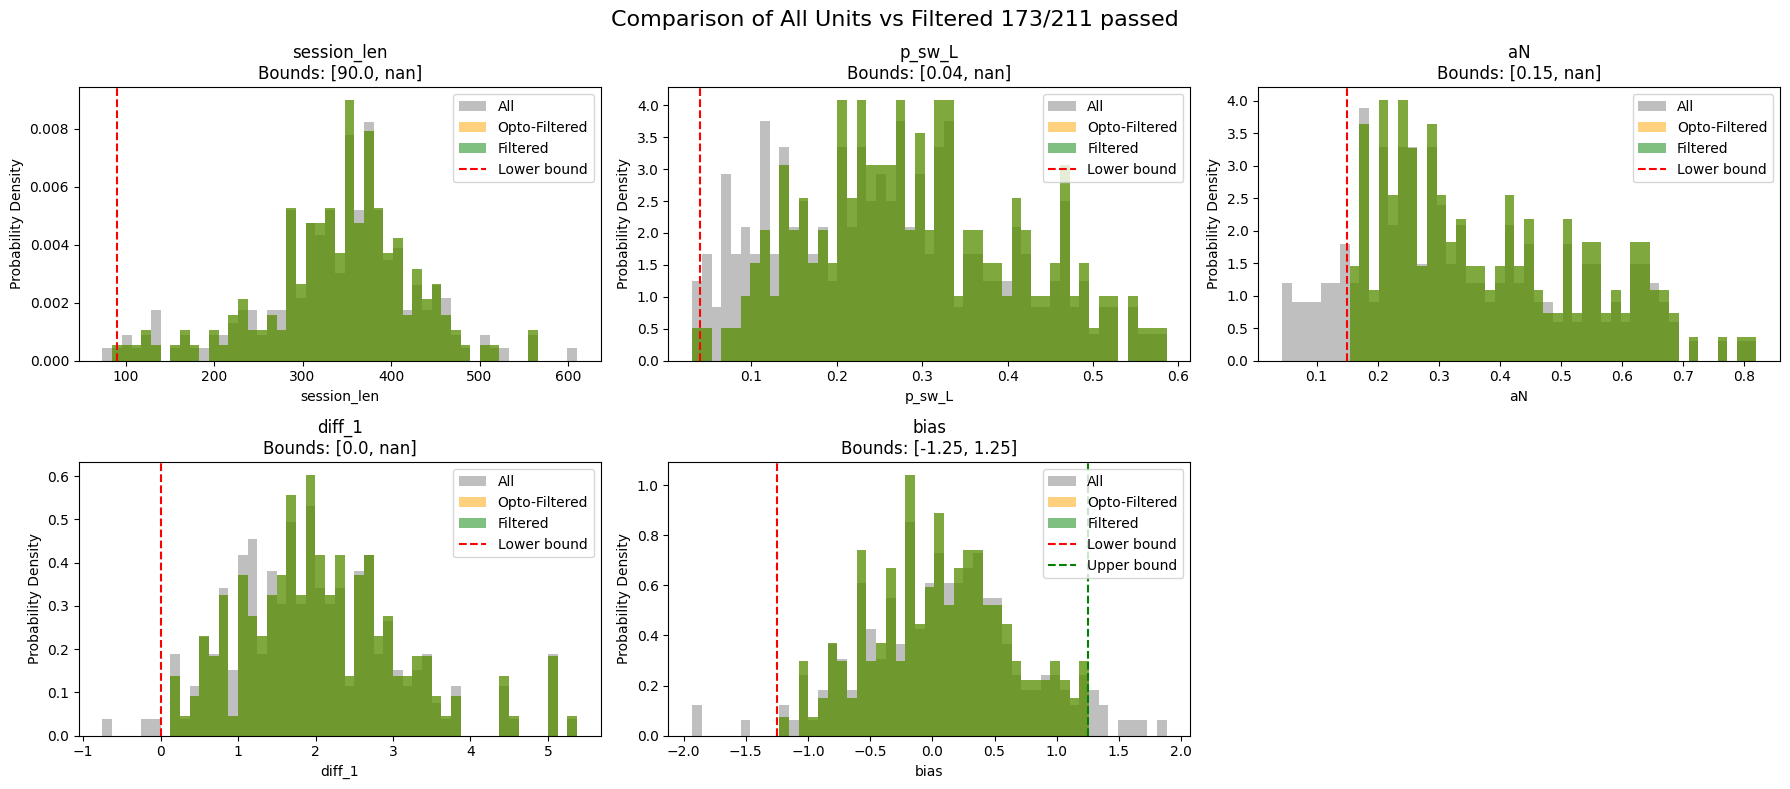

In [55]:
beh_criteria = 'beh_only'
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{beh_criteria}.json'), 'r') as f:
    beh_constraints = json.load(f)
combined_session_tbl_filtered, combined_session_tbl, fig = apply_qc(combined_session_tbl, beh_constraints)

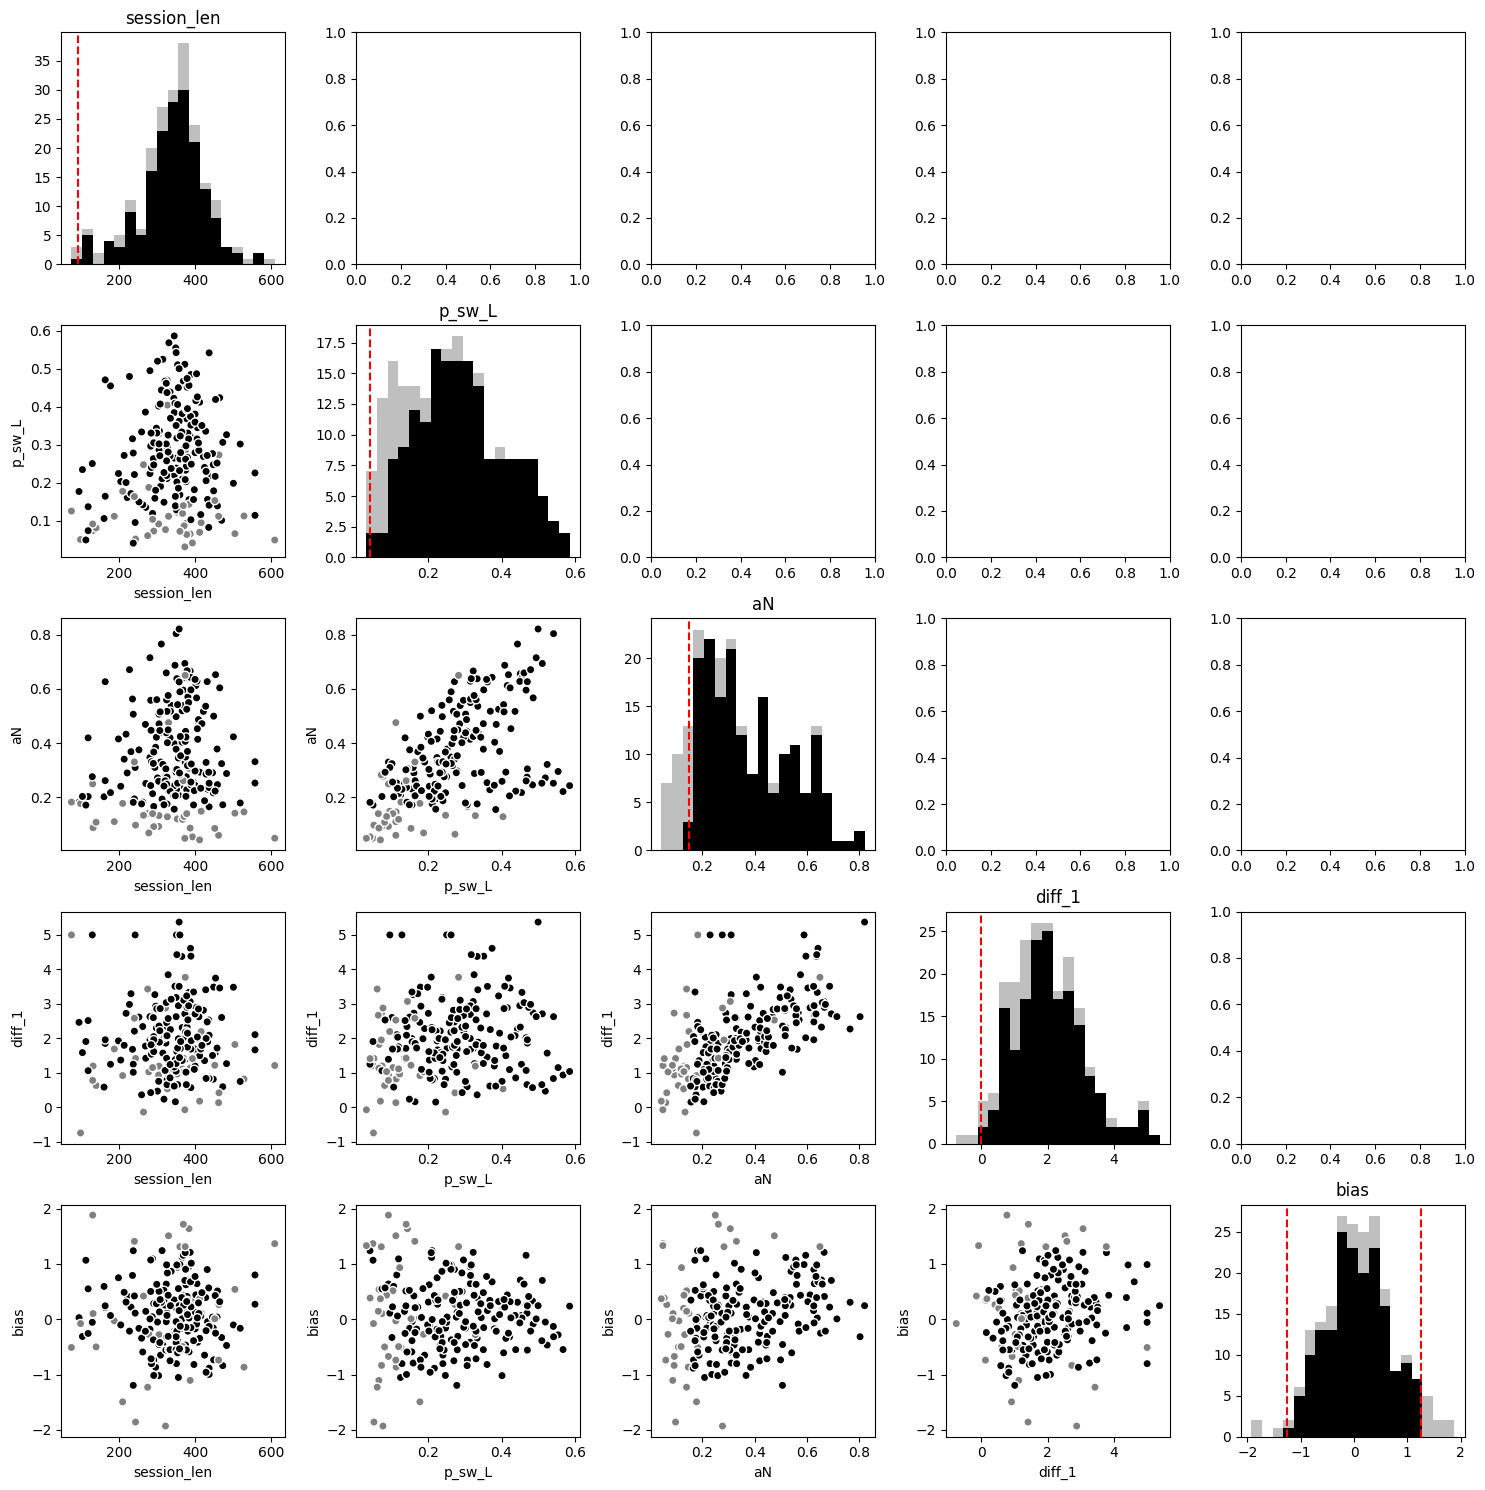

In [56]:
# scatter plot of qm_cols and color code pass vs fail
qm_cols = beh_constraints.keys()
fig, axes = plt.subplots(len(qm_cols), len(qm_cols), figsize=(15,15))
for i, col_x in enumerate(qm_cols):
    for j, col_y in enumerate(qm_cols):
        ax = axes[j, i]
        if i == j:
            bins = np.linspace(combined_session_tbl[col_x].min(), combined_session_tbl[col_x].max(), 20)
            ax.hist(combined_session_tbl[col_x].dropna(), bins=bins, edgecolor=None, facecolor = 'gray', alpha=0.5)
            ax.hist(combined_session_tbl_filtered[col_x].dropna(), bins=bins, edgecolor=None, facecolor = 'k', alpha=1)
            ax.set_title(col_x)
            for boundary in beh_constraints[col_x]['bounds']:
                if boundary is not None:
                    ax.axvline(boundary, color='red', linestyle='--')

        elif i < j:
            ax.scatter(combined_session_tbl[col_x], combined_session_tbl[col_y], 
                        c=combined_session_tbl['session_id'].isin(combined_session_tbl_filtered['session_id']).map({True: 'k', False: 'gray'}), 
                        alpha=1, edgecolors='white')
    
            ax.set_xlabel(col_x)
            ax.set_ylabel(col_y)
plt.tight_layout()

plt.savefig(os.path.join(target_folder, 'behavior_qm_scatter.pdf'))


In [57]:
session_list = combined_session_tbl_filtered['session_id'].tolist()

model_name = 'stan_qLearning_5params'


In [58]:
# comcation of all sessionss
# pe, p_Right, Q_R, Q_L, policy_change, policy_update_mean etc
focus_cols = ['outcome', 'choice',
                'Q_r', 'Q_l', 'pe', 'p_Right', 'p_Right_glm', 'pChoice', 'pChoice_glm',
                'policy_change', 'policy_change_log_odd', 'policy_update_mean', 
                'policy_glm_change', 'policy_glm_change_log_odd', 'policy_glm_update_mean']
count_win = [0, 1]
def process(session):
    print(session)
    if get_session_tbl(session) is not None:
        sess_df = makeSessionDF(session, model_name=model_name, cut_interruptions=True, load_glm=True)
        if 'pChoice' in sess_df.columns:
             # compute p_Right
            p_right = sess_df['pChoice'].values.copy()
            p_right[sess_df['choice']==0] = 1 - p_right[sess_df['choice']==0]
            sess_df['p_Right'] = p_right
        if 'pChoice_glm' in sess_df.columns:
            p_right_glm = sess_df['pChoice_glm'].values.copy()
            p_right_glm[sess_df['choice']==0] = 1 - p_right_glm[sess_df['choice']==0]
            sess_df['p_Right_glm'] = p_right_glm
        # select focus columns that is included in the session dataframe and set the ones that are not included to NaN
        # count number of licks after outcome
        lick_data = load_licks(session)
        all_licks = np.concatenate((lick_data['licks_L_cleaned'], lick_data['licks_R_cleaned']))
        all_licks = np.sort(all_licks)
        align_times = sess_df['outcome_time'].values
        lick_counts = np.full(len(align_times), np.nan)
        for i, align_time in enumerate(align_times):
            lick_counts[i] = np.sum((all_licks >= align_time + count_win[0]) & (all_licks < align_time + count_win[1]))
        sess_df['lick_rate_post_outcome'] = lick_counts/(count_win[1]-count_win[0])

        for col in focus_cols:
            if col not in sess_df.columns:
                sess_df[col] = np.nan
        return sess_df, session
    else:
        return None, session
        


In [59]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=-1)(delayed(process)(session) for session in session_list)
# all_sess_df = pd.concat(all_sess_dfs, ignore_index=True)

behavior_716325_2024-05-29_10-33-32
behavior_751769_2025-01-16_11-32-05
behavior_751004_2024-12-22_13-09-17
behavior_751769_2025-01-17_11-37-39
behavior_751769_2025-01-18_10-15-25
behavior_758017_2025-02-04_11-57-38
behavior_758017_2025-02-05_11-42-34
behavior_758017_2025-02-06_11-26-14
behavior_751766_2025-02-15_12-08-11
behavior_751766_2025-02-11_11-53-38
behavior_751766_2025-02-13_11-31-21
behavior_751181_2025-02-25_12-12-35
behavior_751766_2025-02-14_11-37-11
behavior_751181_2025-02-26_11-51-19
behavior_754897_2025-03-12_12-23-15
behavior_758018_2025-03-20_11-53-05
behavior_758018_2025-03-21_11-00-34
behavior_752014_2025-03-26_11-18-57
behavior_752014_2025-03-27_12-03-59
behavior_752014_2025-03-28_11-04-59
behavior_761038_2025-04-15_10-25-11
behavior_761038_2025-04-16_10-39-10
behavior_761038_2025-04-18_12-37-39
behavior_782394_2025-04-23_10-51-17
behavior_782394_2025-04-24_12-07-34
behavior_782394_2025-04-25_11-13-21
behavior_763590_2025-05-01_10-59-18
behavior_763590_2025-05-02_1

In [60]:
all_sess_df, processed_sessions = [], []
for res in results:
    if res[0] is not None:
        all_sess_df.append(res[0])
        processed_sessions.append(res[1])

In [61]:
for sess_id, sess_df in enumerate(all_sess_df):
    if sess_df is None or sess_df.empty:
        print(f'Session {processed_sessions[sess_id]} is empty')
        continue
    if 'outcome' not in sess_df.columns:
        print(f'Outcome not in {processed_sessions[sess_id]}')

In [62]:
session_len = [len(sess_df) for sess_df in all_sess_df]
session_len_time = [(sess_df['goCue_start_time'].iloc[-1] - sess_df['goCue_start_time'].iloc[0])/60 if sess_df is not None else np.nan for sess_df in all_sess_df]
p_correct = [np.mean(sess_df['pChoice']>=0.5) if sess_df is not None and 'pChoice' in sess_df.columns else np.nan for sess_df in all_sess_df]
# set p_correct is 0 to np.nan
p_correct = [p if p>0 else np.nan for p in p_correct]

p_correct_glm = [np.mean(sess_df['pChoice_glm']>=0.5) if sess_df is not None and 'pChoice_glm' in sess_df.columns else np.nan for sess_df in all_sess_df]
# set p_correct_glm is 0 to np.nan
reward_rate = [np.mean(sess_df['outcome']) if sess_df is not None else np.nan for sess_df in all_sess_df ]

summary_df = pd.DataFrame({'session_id': processed_sessions,
                            'session_len': session_len,
                            'session_len_time': session_len_time,
                            'p_correct': p_correct,
                            'p_correct_glm': p_correct_glm,
                            'reward_rate': reward_rate})



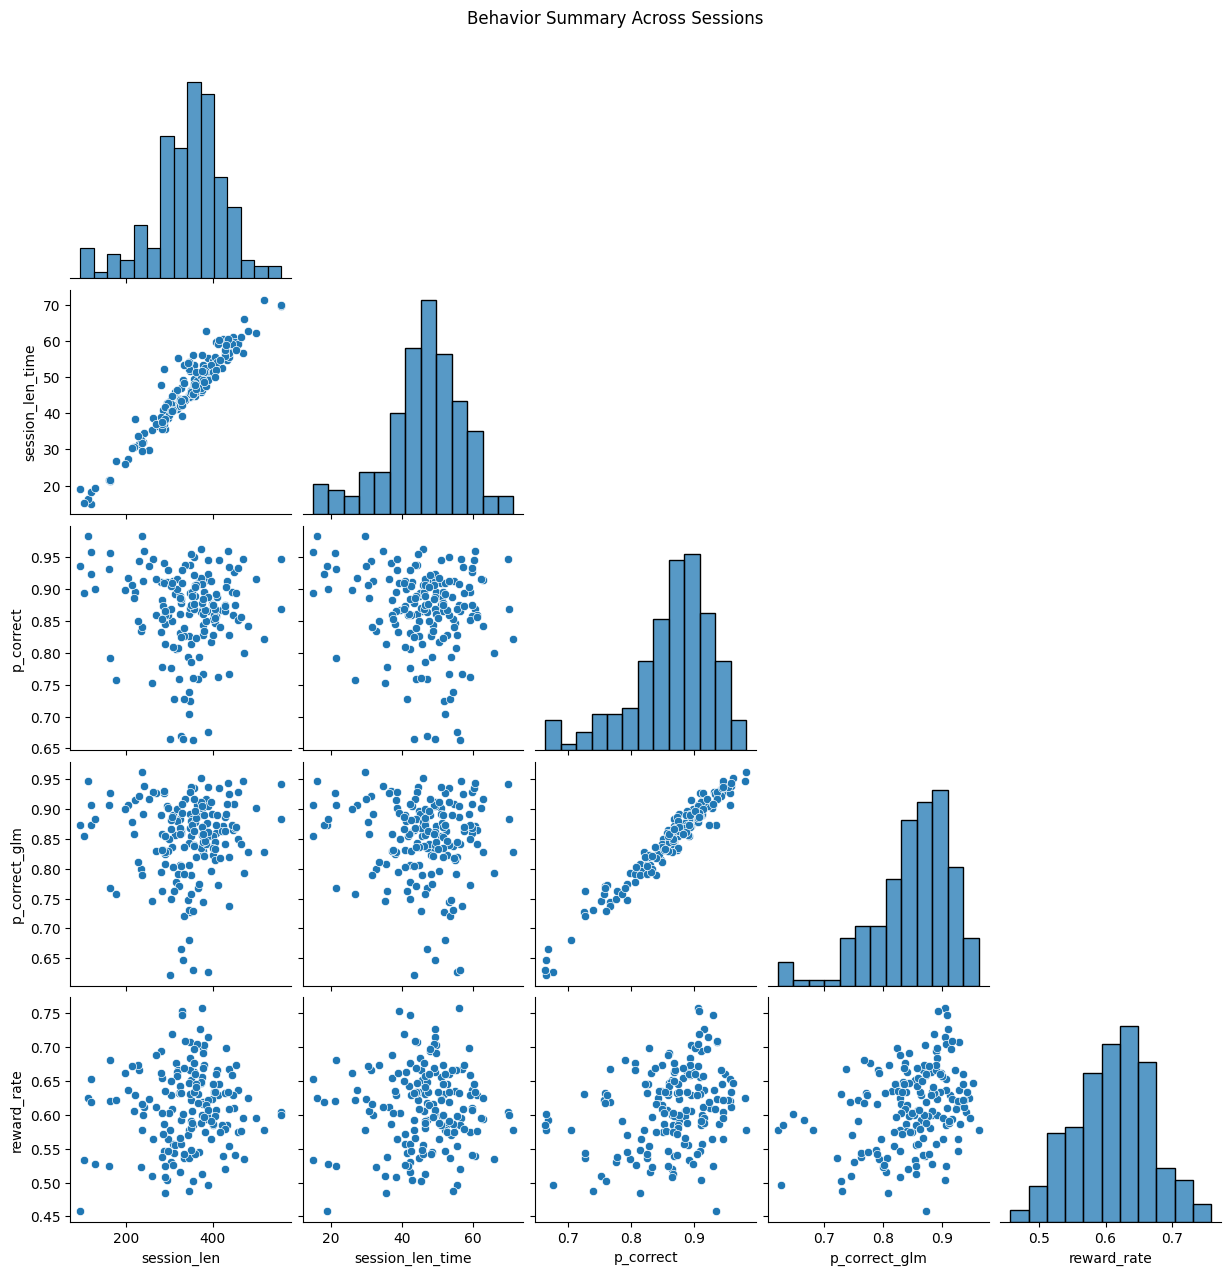

In [63]:
g = sns.pairplot(summary_df[['session_len', 'session_len_time', 'p_correct', 'p_correct_glm', 'reward_rate']], corner=True)
g.fig.suptitle('Behavior Summary Across Sessions', y=1.02)
plt.savefig(os.path.join(target_folder, 'model_prediction_summary_scatter.pdf'))

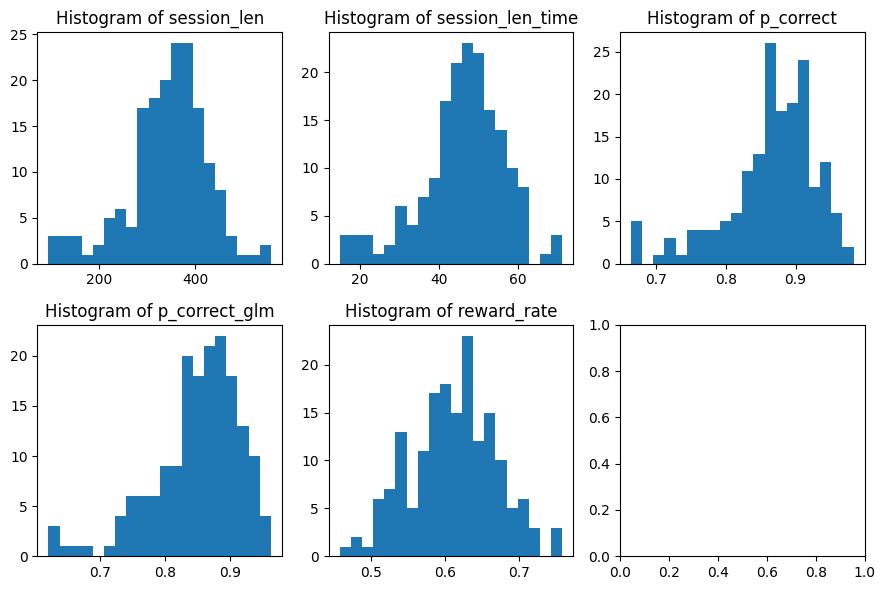

In [64]:
# histogram of all summary stats
focus_cols = ['session_len', 'session_len_time', 'p_correct', 'p_correct_glm', 'reward_rate']
fig, axes = plt.subplots(2, 3, figsize=(9,6))
for i, col in enumerate(focus_cols):
    ax = axes[i//3, i%3]
    ax.hist(summary_df[col].dropna(), bins=20, edgecolor=None)
    ax.set_title(f'Histogram of {col}')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'behavior_summary_stats_histogram.pdf'))

## RL parameters

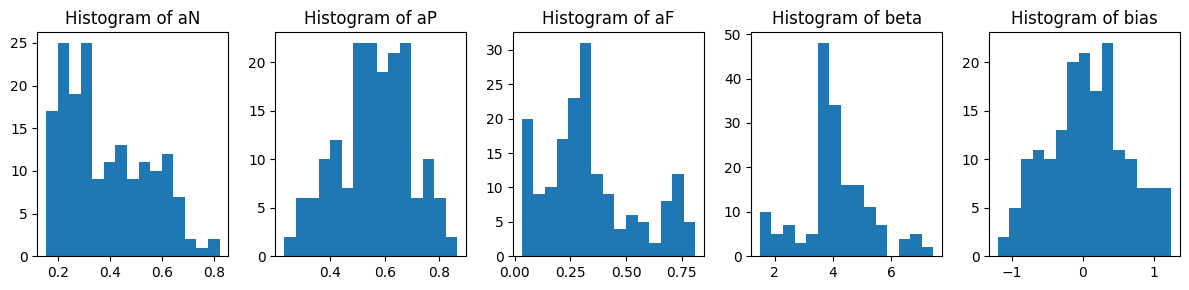

In [65]:
focus_params = ['aN', 'aP', 'aF', 'beta', 'bias']
fig, axes = plt.subplots(1, len(focus_params), figsize=(12,3))
for i, param in enumerate(focus_params):
    ax = axes[i]
    param_values = combined_session_tbl_filtered[param].dropna().values
    ax.hist(param_values, bins=15, edgecolor=None)
    ax.set_title(f'Histogram of {param}')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'behavior_model_params_histogram.pdf'))

## Policy against RPE

In [66]:
policy_columns = ['policy_change', 'policy_change_log_odd', 'policy_update_mean', 'policy_glm_change', 'policy_glm_change_log_odd', 'policy_glm_update_mean']

In [67]:
all_session_combined = pd.concat(objs=all_sess_df, ignore_index=True)
num_bins = 9
bin_qualties = False

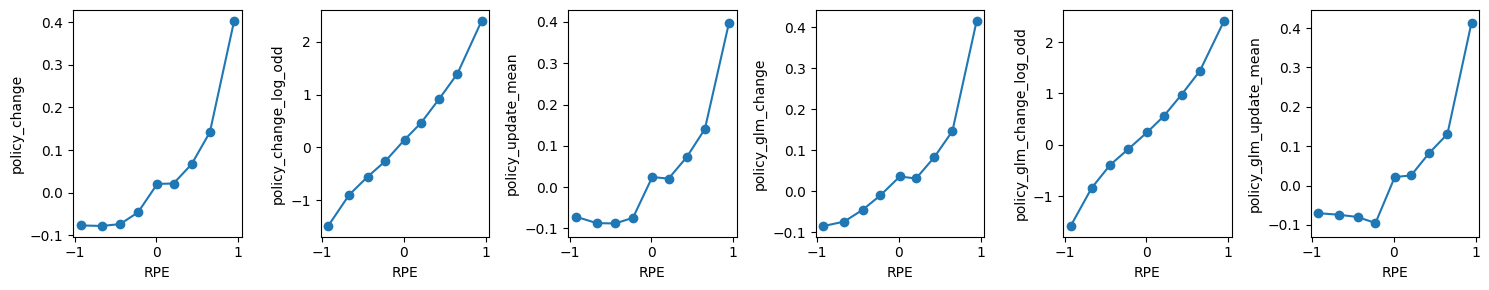

In [68]:
fig, axes = plt.subplots(1, len(policy_columns), figsize=(15, 3))
for i, col in enumerate(policy_columns):
    ax = axes[i]
    data = all_session_combined[col].values
    rpe = all_session_combined['pe'].values
    valid_idx = ~np.isnan(data) & ~np.isnan(rpe)
    data = data[valid_idx]
    rpe = rpe[valid_idx]
    if not bin_qualties:
        bins = np.linspace(np.nanmin(rpe), np.nanmax(rpe), num_bins+1) 
    else:
        bins = np.quantile(rpe, np.linspace(0, 1, num_bins+1))
    bin_means = np.full(num_bins, np.nan)
    policy_means = np.full(num_bins, np.nan)
    policy_sems = np.full(num_bins, np.nan)
    for ind in range(num_bins):
        bin_idx = (rpe >= bins[ind]) & (rpe < bins[ind+1])
        if np.sum(bin_idx) > 0:
            bin_means[ind] = np.nanmean(rpe[bin_idx])
            policy_means[ind] = np.nanmean(data[bin_idx])
            policy_sems[ind] = np.std(data[bin_idx])/np.sqrt(np.sum(bin_idx))
    ax.errorbar(bin_means, policy_means, yerr=policy_sems, fmt='-o')
    ax.set_xlabel('RPE')
    ax.set_ylabel(col)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'policies_vs_rpe_all_combined.pdf'))


## policy vs rpe, calculate by session then combine

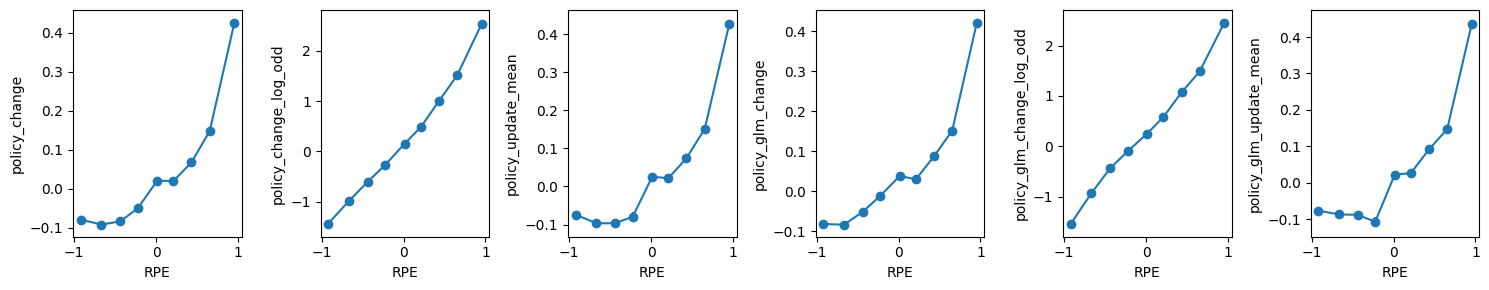

In [69]:
fig, axes = plt.subplots(1, len(policy_columns), figsize=(15, 3))

for i, col in enumerate(policy_columns):
    ax = axes[i]
    policy_mat = []
    rpe_mat = []
    for sess_df in all_sess_df:
        data = sess_df[col].values
        rpe = sess_df['pe'].values
        valid_idx = ~np.isnan(data) & ~np.isnan(rpe)
        data = data[valid_idx]
        rpe = rpe[valid_idx]
        if len(data) == 0:
            continue
        if not bin_qualties:
            bins = np.linspace(np.nanmin(rpe), np.nanmax(rpe), num_bins+1) 
        else:
            bins = np.quantile(rpe, np.linspace(0, 1, num_bins+1))
        bin_means = np.full(num_bins, np.nan)
        policy_means = np.full(num_bins, np.nan)
        for ind in range(num_bins):
            bin_idx = (rpe >= bins[ind]) & (rpe < bins[ind+1])
            if np.sum(bin_idx) > 0:
                bin_means[ind] = np.nanmean(rpe[bin_idx])
                policy_means[ind] = np.nanmean(data[bin_idx])
        rpe_mat.append(bin_means)
        policy_mat.append(policy_means)
    rpe_mat = np.array(rpe_mat)
    policy_mat = np.array(policy_mat)
    mean_rpe = np.nanmean(rpe_mat, axis=0)
    mean_policy = np.nanmean(policy_mat, axis=0)
    sem_policy = np.nanstd(policy_mat, axis=0)/np.sqrt(np.sum(~np.isnan(policy_mat), axis=0))
    ax.errorbar(mean_rpe, mean_policy, yerr=sem_policy, fmt='-o')
    ax.set_xlabel('RPE')
    ax.set_ylabel(col)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'policies_vs_rpe_session_avg.pdf'))


## Lick rate vs rpe

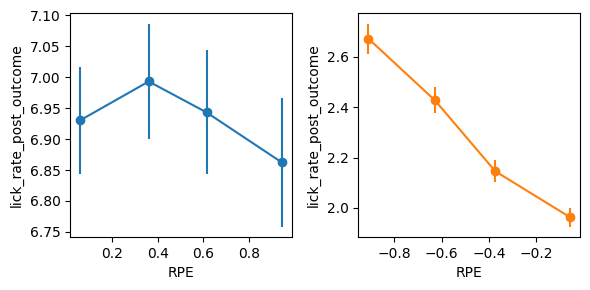

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
col = 'lick_rate_post_outcome'
lick_mat = []
rpe_mat = []
bin_quantiles = False
num_bins = 8
for sess_df in all_sess_df:
    data = sess_df[col].values
    rpe = sess_df['pe'].values
    valid_idx = ~np.isnan(data) & ~np.isnan(rpe)
    data = data[valid_idx]
    rpe = rpe[valid_idx]
    if len(data) == 0:
        continue
    if not bin_quantiles:
        bins = np.concat((np.linspace(-1, 0, num_bins//2 +1), np.linspace(0, 1, num_bins//2 +1)[1:]))
    else:
        bins = np.quantile(rpe, np.linspace(0, 1, num_bins+1))
    bin_means = np.full(num_bins, np.nan)
    lick_means = np.full(num_bins, np.nan)
    for ind in range(num_bins):
        bin_idx = (rpe >= bins[ind]) & (rpe < bins[ind+1])
        if np.sum(bin_idx) > 0:
            bin_means[ind] = np.nanmean(rpe[bin_idx])
            lick_means[ind] = np.nanmean(data[bin_idx])
    rpe_mat.append(bin_means)
    lick_mat.append(lick_means)
rpe_mat = np.array(rpe_mat)
lick_mat = np.array(lick_mat)
mean_rpe = np.nanmean(rpe_mat, axis=0)

mean_policy = np.nanmean(lick_mat, axis=0)
sem_policy = np.nanstd(lick_mat, axis=0)/np.sqrt(np.sum(~np.isnan(lick_mat), axis=0))
# plot lick with postive and negative rpe separately
ax = axes[0]
pos_idx = mean_rpe >= 0
ax.errorbar(mean_rpe[pos_idx], mean_policy[pos_idx], yerr=sem_policy[pos_idx], fmt='-o', color='tab:blue')
ax.set_xlabel('RPE')
ax.set_ylabel(col)
ax = axes[1]
neg_idx = mean_rpe < 0
ax.errorbar(mean_rpe[neg_idx], mean_policy[neg_idx], yerr=sem_policy[neg_idx], fmt='-o', color='tab:orange')
ax.set_xlabel('RPE')
ax.set_ylabel(col)
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'licks_vs_rpe_session_avg.pdf'))


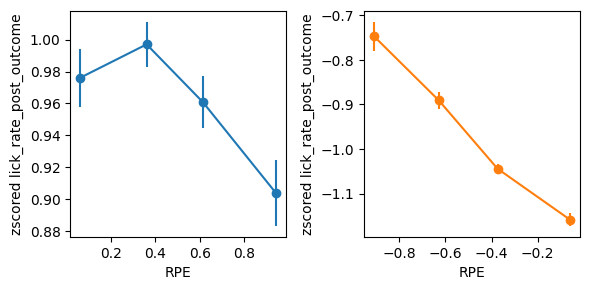

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
col = 'lick_rate_post_outcome'
lick_mat = []
rpe_mat = []
bin_quantiles = False
num_bins = 8
for sess_df in all_sess_df:
    data = sess_df[col].values
    rpe = sess_df['pe'].values
    valid_idx = ~np.isnan(data) & ~np.isnan(rpe)
    data = data[valid_idx]
    rpe = rpe[valid_idx]
    if len(data) == 0:
        continue
    if not bin_quantiles:
        bins = np.concat((np.linspace(-1, 0, num_bins//2 +1), np.linspace(0, 1, num_bins//2 +1)[1:]))
    else:
        bins = np.quantile(rpe, np.linspace(0, 1, num_bins+1))
    bin_means = np.full(num_bins, np.nan)
    lick_means = np.full(num_bins, np.nan)
    for ind in range(num_bins):
        bin_idx = (rpe >= bins[ind]) & (rpe < bins[ind+1])
        if np.sum(bin_idx) > 0:
            bin_means[ind] = np.nanmean(rpe[bin_idx])
            lick_means[ind] = np.nanmean(data[bin_idx])
    lick_means[~np.isnan(lick_means)] = zscore(lick_means[~np.isnan(lick_means)])
    rpe_mat.append(bin_means)
    lick_mat.append(lick_means)
rpe_mat = np.array(rpe_mat)
lick_mat = np.array(lick_mat)
mean_rpe = np.nanmean(rpe_mat, axis=0)

mean_policy = np.nanmean(lick_mat, axis=0)
sem_policy = np.nanstd(lick_mat, axis=0)/np.sqrt(np.sum(~np.isnan(lick_mat), axis=0))
# plot lick with postive and negative rpe separately
ax = axes[0]
pos_idx = mean_rpe >= 0
ax.errorbar(mean_rpe[pos_idx], mean_policy[pos_idx], yerr=sem_policy[pos_idx], fmt='-o', color='tab:blue')
ax.set_xlabel('RPE')
ax.set_ylabel(f'zscored {col}')
ax = axes[1]
neg_idx = mean_rpe < 0
ax.errorbar(mean_rpe[neg_idx], mean_policy[neg_idx], yerr=sem_policy[neg_idx], fmt='-o', color='tab:orange')
ax.set_xlabel('RPE')
ax.set_ylabel(f'zscored {col}')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, 'zscored_licks_vs_rpe_session_avg.pdf'))


In [90]:
def plot_scatter_by_category(plot_col, cate_col):
    plot_mean_1 = []
    plot_mean_0 = []
    animal_ids = []
    for sess_df, session_id in zip(all_sess_df, processed_sessions):
        animal_id, _, _ = parseSessionID(session_id)
        data = sess_df[plot_col].values
        cat_val = sess_df[cate_col].values
        valid_idx = ~np.isnan(data) & ~np.isnan(cat_val)
        data = data[valid_idx]
        cat_val = cat_val[valid_idx]
        if len(data) == 0:
            continue
        plot_mean_1.append(np.nanmean(data[cat_val==1]))
        plot_mean_0.append(np.nanmean(data[cat_val==0]))
        animal_ids.append(animal_id)
    fig, ax = plt.subplots(figsize=(6,6))
    plot_df = pd.DataFrame({f'{plot_col}{cate_col}=1': plot_mean_1,
                                f'{plot_col}{cate_col}=0': plot_mean_0,
                                'animal_id': animal_ids})
    g = sns.scatterplot(data=plot_df, x=f'{plot_col}{cate_col}=0', y=f'{plot_col}{cate_col}=1', hue='animal_id', s=30, ax=ax)
    max_val = max(plot_df[f'{plot_col}{cate_col}=1'].max(), plot_df[f'{plot_col}{cate_col}=0'].max())
    ax.plot([0, max_val], [0, max_val], 'k--')
    ax.set_xlabel(f'Mean {plot_col} {cate_col}=0')
    ax.set_ylabel(f'Mean {plot_col} {cate_col}=1')
    plt.tight_layout()
    plt.savefig(os.path.join(target_folder, f'{plot_col}_{cate_col}_scatter_animal_color.pdf'))
    print(f'Saved figure to {target_folder} as {plot_col}_{cate_col}_scatter_animal_color.pdf')

Saved figure to /root/capsule/scratch/manuscript/F_beh as lick_rate_post_outcome_outcome_scatter_animal_color.pdf


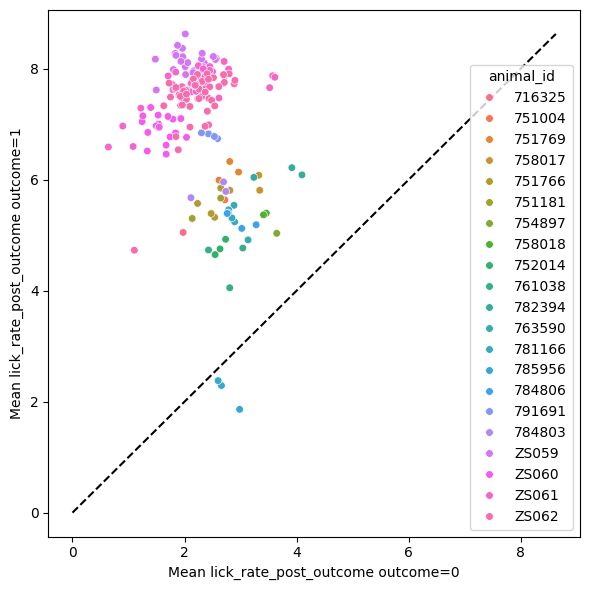

In [91]:
plot_scatter_by_category('lick_rate_post_outcome', 'outcome')

## Lick rate compare switch and stay

Saved figure to /root/capsule/scratch/manuscript/F_beh as lick_rate_post_outcome_svs_scatter_animal_color.pdf


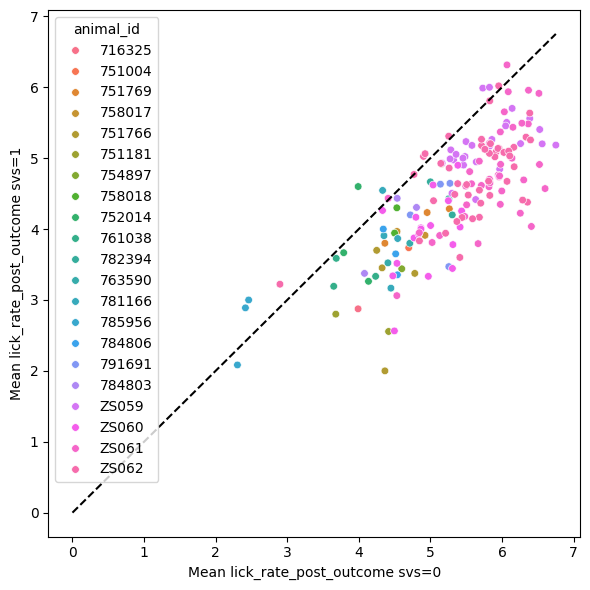

In [93]:
plot_scatter_by_category('lick_rate_post_outcome', 'svs')

Saved figure to /root/capsule/scratch/manuscript/F_beh as lick_lat_svs_scatter_animal_color.pdf


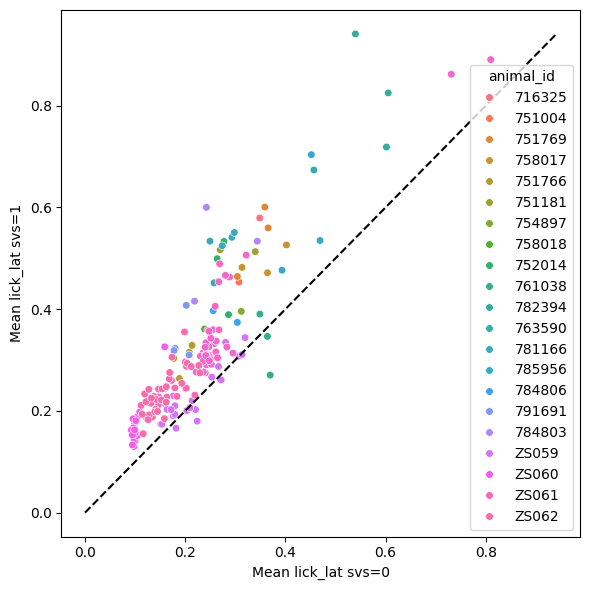

In [94]:
plot_scatter_by_category('lick_lat', 'svs')